# **Elaborato per il corso di Hands on Labs, MD2SL 2024**
## **Rete comvoluzionale per super-risoluzione (a colori)**
## *Dario Comanducci*

## Dataset RGB per super-risoluzione 

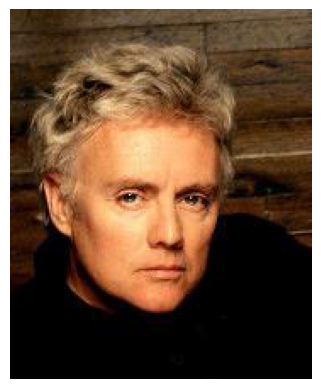

In [1]:
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

img_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/img_align_celeba/'
fid = '000030.jpg'
orig_img = Image.open(path.join(img_path, fid))
plt.imshow(np.array(orig_img))
plt.axis('off')
plt.show()

In [2]:
import pandas as pd
import datetime

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, ToPILImage, Compose, Normalize, InterpolationMode, v2


#normalizeRgb = Compose([ToTensor(), Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
normalizeRgb = Compose([ToTensor()])


class ImageRgbDataset(Dataset):
    
    # metodo statico per creare le immagini a bassa/alta risoluzione a partire dalla lista di immagini
    @staticmethod
    def LoadLHRImages(img_dir, df_set):
        img_names = df_set.index.values

        printed = -1
        counter = 0
        
        imgLR = []
        imgHR = []
        tot = len(img_names)
        first_time = datetime.datetime.now()
        for fid in img_names:
            img = Image.open(path.join(img_dir, fid))
            
            cropped  = v2.CenterCrop(size=(168,168))(img) 
            target   = v2.Resize(size=(84,84), interpolation=InterpolationMode.BICUBIC)(cropped)
            resized  = v2.Resize(size=(28,28), interpolation=InterpolationMode.BICUBIC)(cropped)
            interp   = v2.Resize(size=(84,84), interpolation=InterpolationMode.BICUBIC)(resized)
            
            imgLR.append(interp)
            imgHR.append(target)

            # mostra avanzamento del caricamento e stima del tempo rimasto
            counter += 1
            perc = counter/tot
            perc100 = np.floor(perc*10)*10
            if printed != perc100:
                printed = perc100
                later_time = datetime.datetime.now()
                diff = later_time - first_time
                toClose = diff*(tot-counter)/counter
                print('   # {}/{} ({}%) {}'.format(counter, tot, perc100, toClose))

        return (imgLR, imgHR)

#--------------------------------------------------------------------------------------------------------------------------    
    
    def __init__(self, X_data, y_data):
        nImgs = len(X_data)
        
        self.X = []
        self.y = []
        self.img_X = []
        self.img_y = []
        
        counter = 0
        printed = -1
        for k in range(nImgs):
            imgLR = X_data[k]
            imgHR = y_data[k]
            
            #self.img_X.append(ToTensor()(imgLR))
            self.img_X.append(normalizeRgb(imgLR))
            patches = self.split_image(imgLR,3,3)
            for p in patches:
                #self.X.append(ToTensor()(p))
                self.X.append(normalizeRgb(p))
            
            #self.img_y.append(ToTensor()(imgHR))
            self.img_y.append(normalizeRgb(imgHR))
            patches = self.split_image(imgHR,3,3)
            for p in patches:
                #self.y.append(ToTensor()(p))
                self.y.append(normalizeRgb(p))

            # mostra avanzamento della scomposizione in patch
            counter += 1
            perc = counter/nImgs
            perc100 = np.floor(perc*10)*10
            if printed != perc100:
                printed = perc100
                print('   # {}/{} ({}%)'.format(counter, nImgs, perc100))
                
#--------------------------------------------------------------------------------------------------------------------------
            
    def split_image(self, image, rows, cols):
        width, height = image.size
        patch_width = width // cols
        patch_height = height // rows
    
        patches = []
        for i in range(rows):
            for j in range(cols):
                x1 = j * patch_width
                y1 = i * patch_height
                x2 = x1 + patch_width
                y2 = y1 + patch_height
                patch = image.crop((x1, y1, x2, y2))
                patches.append(patch)
    
        return patches

#--------------------------------------------------------------------------------------------------------------------------
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

#--------------------------------------------------------------------------------------------------------------------------
    
    def __len__ (self):
        return len(self.X)
#--------------------------------------------------------------------------------------------------------------------------
    
    def getImages(self, index):
        return self.img_X[index], self.img_y[index]
    
#--------------------------------------------------------------------------------------------------------------------------

    def size(self):
        return len(self.X)

#--------------------------------------------------------------------------------------------------------------------------

    def examples(self):
        return len(self.img_X)

#--------------------------------------------------------------------------------------------------------------------------
    def plotExample(self, item, showPacthes=False):
        (X,y) = self.getImages(item)
        # denormalizzo le immagini
        X = ImageRgbDataset.denormalize(X)
        y = ImageRgbDataset.denormalize(y)
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(np.array(ToPILImage()(X)), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('input')
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(np.array(ToPILImage()(y)), cmap='gray', vmin=0, vmax=255)
        ax.set_title('target')
        ax.set_axis_off()
        plt.show()
    
        if showPacthes:
            
            fig, ax = plt.subplots(3,6, figsize=(6, 3)) #
            
            pos = item*9
            for i in range(3):
                for j in range(3):
                    sh = i*3+j

                    (Xp,yp) = self.__getitem__(pos+sh)
                    Xp = ImageRgbDataset.denormalize(Xp)
                    yp = ImageRgbDataset.denormalize(yp)
                    
                    ax[i,j].imshow(np.array(ToPILImage()(Xp)))
                    ax[i,j].set_axis_off()
                    
                    ax[i,j+3].imshow(np.array(ToPILImage()(yp)))
                    ax[i,j+3].set_axis_off()
    
    
            plt.tight_layout()
            plt.show()

    @staticmethod
    def denormalize(imgNorm):
        #img = (imgNorm /2) + 0.5
        return imgNorm

    # def denormalize(imgNorm):
    #     img = (imgNorm /2) + 0.5
    #     return img
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


Carichiamo quindi in memoria training set e validation set, mostrando un esempio per ciascuno di essi

In [3]:
fpath = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/CelebA/'
df_part = pd.read_csv(fpath + 'list_eval_partition.txt', sep=" ", index_col=0, header=None, names=['set'])

img_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/img_align_celeba/'
set_labels = {0: 'train', 1: 'valid', 2: 'test'}
df_part['set'] = df_part['set'].replace(set_labels)



TRAINING SET
   # 1/32554 (0.0%) 0:00:00
   # 3256/32554 (10.0%) 0:00:29.971872
   # 6511/32554 (20.0%) 0:00:33.820709
   # 9767/32554 (30.0%) 0:00:37.017485
   # 13022/32554 (40.0%) 0:00:37.327329
   # 16277/32554 (50.0%) 0:00:35.590104
   # 19533/32554 (60.0%) 0:00:32.162649
   # 22788/32554 (70.0%) 0:00:26.933531
   # 26044/32554 (80.0%) 0:00:19.840294
   # 29299/32554 (90.0%) 0:00:10.872583
   # 32554/32554 (100.0%) 0:00:00
   # 1/32554 (0.0%)
   # 3256/32554 (10.0%)
   # 6511/32554 (20.0%)
   # 9767/32554 (30.0%)
   # 13022/32554 (40.0%)
   # 16277/32554 (50.0%)
   # 19533/32554 (60.0%)
   # 22788/32554 (70.0%)
   # 26044/32554 (80.0%)
   # 29299/32554 (90.0%)
   # 32554/32554 (100.0%)
0:26:42.588596


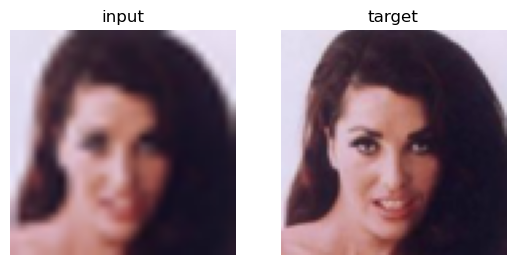

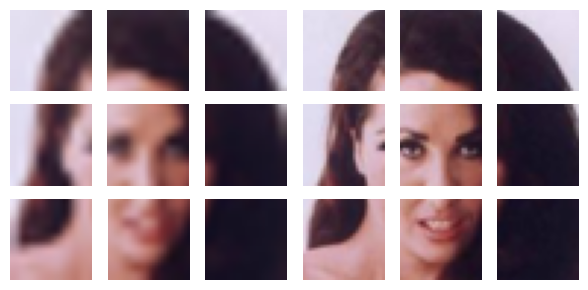


VALIDATION SET
   # 1/19867 (0.0%) 0:06:22.579428
   # 1987/19867 (10.0%) 0:02:18.252218
   # 3974/19867 (20.0%) 0:02:03.007157
   # 5961/19867 (30.0%) 0:01:49.387265
   # 7947/19867 (40.0%) 0:01:35.737224
   # 9934/19867 (50.0%) 0:01:21.787641
   # 11921/19867 (60.0%) 0:01:07.108483
   # 13907/19867 (70.0%) 0:00:51.580967
   # 15894/19867 (80.0%) 0:00:35.356057
   # 17881/19867 (90.0%) 0:00:18.114499
   # 19867/19867 (100.0%) 0:00:00
   # 1/19867 (0.0%)
   # 1987/19867 (10.0%)
   # 3974/19867 (20.0%)
   # 5961/19867 (30.0%)
   # 7947/19867 (40.0%)
   # 9934/19867 (50.0%)
   # 11921/19867 (60.0%)
   # 13907/19867 (70.0%)
   # 15894/19867 (80.0%)
   # 17881/19867 (90.0%)
   # 19867/19867 (100.0%)
0:13:29.078961


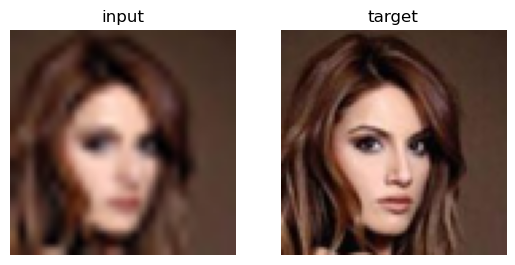

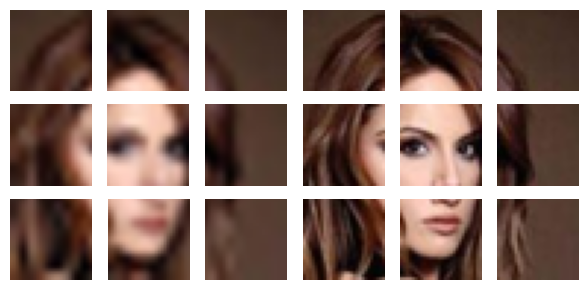

In [4]:
idTrain = df_part[df_part['set'] == 'train'].index
idValid = df_part[df_part['set'] == 'valid'].index

df_train = df_part.loc[idTrain[::5]]
df_valid = df_part.loc[idValid]

print('\nTRAINING SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageRgbDataset.LoadLHRImages(img_path, df_train)
trRgbDataset = ImageRgbDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
trRgbDataset.plotExample(2, True)

print('\nVALIDATION SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageRgbDataset.LoadLHRImages(img_path, df_valid)
vlRgbDataset = ImageRgbDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
vlRgbDataset.plotExample(2, True)

## La rete convoluzionale

Tra i vari spazi colore impiegati da Dong et al., il risultato migliore è stato ottenuto su immagini RGB. L'architettura ed il dimensionamento della rete sono come nella rete in scala di grigi ad eccezione del numero di canali in ingresso al primo layer ($c_1=3$) e di quelli in uscita all'ultimo strato ($c_3=3$): 3 layer convoluzionali con kernel di dimensione $c_k \times f_k \times f_k$, il cui output è formato da $n_k$ "immagini" convolute ($k=1,2,3$ andando dall'ingresso verso l'uscita), dove
* $n_1=64$, $f_1 = 9$, $c_1 = 3$
* $n_2=32$, $f_2 = 1$, $c_2 = 64$
* $n_3=3$, $f_3 = 5$, $c_3 = 32$

Differentemente da DOng et al., in catena alla ReLU dell'ultimo layer è stata qui aggiunta la tangente iperbolica, in modo che i valori in uscita non superino mai 1 (poi scalato in 255 sulle immagini RGB).

L'implementazione di tale rete è costituita dalla classe $\texttt{RgbCNN}$

In [5]:
import torch.nn as nn

class RgbCNN(nn.Module):
    
    def __init__(self):
        super(RgbCNN, self).__init__()
        #NB: bias=True in nn.Conv2d come default
        
        # layer 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, padding_mode='reflect')
        self.relu1 = nn.ReLU()

        # Layer 2
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Layer 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        self.relu3 = nn.ReLU()
        self.reg = nn.Tanh() # per evitare valori sopra 1 (255)
        
#--------------------------------------------------------------------------------------------------------------------------
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.reg(out)

        return out



## Addestramento
La classe monitor e la funzione train() contengono variazioni minime rispetto al notebook in scala di grigi, giusto lo stretto necessario per denormalizzare le immagini a colori.

In [6]:
import torch.cuda
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

class Monitor:
    
    def __init__(self, dataset, idExample=None, saveNet=False):
        self.dataset = dataset
        self.idExample = idExample
        self.createWriter(saveNet)

#--------------------------------------------------------------------------------------------------------------------------
    
    def createWriter(self, saveNet):
        folder1 = datetime.datetime.now().strftime("./runs/%b%d_%H-%M-%S_Godel/")
        self.writer = SummaryWriter()
        folder2 = datetime.datetime.now().strftime("./runs/%b%d_%H-%M-%S_Godel/")        

        # path di salvataggio della rete corrente, fatto in modo da essere nella stessa cartella dove logga writer
        if saveNet:
            if path.exists(folder1):
                folder = folder1
            else:
                folder = folder2    
            self.RPATH = folder + 'CvNet_' 
        else:
            self.RPATH = ""

#--------------------------------------------------------------------------------------------------------------------------
    
    def annotateLoss(self, training_loss, valid_loss, epoch):
        self.writer.add_scalar("Loss/train", training_loss, epoch)
        self.writer.add_scalar("Loss/valid", valid_loss, epoch)

#--------------------------------------------------------------------------------------------------------------------------
    
    def annotatePrediction(self, model, device, epoch):
        if self.idExample != None:
            (X,y) = self.dataset.getImages(self.idExample)
            p = model(X.to(device))

            Xn = ImageRgbDataset.denormalize(X)
            yn = ImageRgbDataset.denormalize(y)
            pn = ImageRgbDataset.denormalize(p)
            img_grid = make_grid([Xn.to('cpu'),pn.to('cpu'),yn.to('cpu')])
            self.writer.add_image('prediction check', img_grid, epoch)

#--------------------------------------------------------------------------------------------------------------------------
    
    def saveNet(self, model, epoch):
        if len(self.RPATH) != 0:
            fname = self.RPATH + str(epoch)
            torch.save(model.state_dict(), fname)

#--------------------------------------------------------------------------------------------------------------------------
    
    @staticmethod
    def createSummary(lr, batch_size, training_size, training_loss, valid_loss, seed):
        summary = {'lr':lr, 'bsize':batch_size, 'tsize':training_size, 'tloss':training_loss, 'vloss':valid_loss, 'seed':seed}
        return summary

#--------------------------------------------------------------------------------------------------------------------------
    
    def close(self, summary): 
        self.writer.flush()
        self.writer.add_hparams({'seed':summary['seed'], 'lr':summary['lr'],  'bsize':summary['bsize'], 'tsize':summary['tsize']}, 
                                {'hparam/tloss': summary['tloss'], 'hparam/vloss': summary['vloss']})
        self.writer.flush()
        self.writer.close()

#___________________________________________________________________________________________________________________________

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cpu", monitor=None):
    
    model.to(device)
    
    trLossVals = []
    vlLossVals = []
    for epoch in range(1, epochs+1):
        
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad() # clear gradients for next train
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward() # backpropagation, compute gradients
            optimizer.step() # apply gradients
            training_loss += loss.data.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)

        with torch.no_grad():
            model.eval()

            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets)
                valid_loss += loss.data.item() * inputs.size(0)
              
            valid_loss /= len(val_loader.dataset)

            if monitor != None:
                monitor.saveNet(model, epoch)
                monitor.annotatePrediction(model, device, epoch)
                monitor.annotateLoss(training_loss, valid_loss, epoch)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, training_loss, valid_loss))
        
        trLossVals.append(training_loss)
        vlLossVals.append(valid_loss)
        
    return (trLossVals, vlLossVals)

## Addestramento finale
L'addestramento della rete ha impiegato gli stessi valori per il learning rate (1e-4) e batch size (64), ma portando il numero di epoche a 400 rispetto alle 200 impiegate nelle rete su scala di grigi. 

In [7]:
import random
mySeed = 313

print('GPU cuda {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

random.seed(mySeed)
torch.manual_seed(mySeed)
np.random.seed(mySeed) 

nEpochs = 400
lr = 0.0001
batch_size = 64

train_dl = DataLoader(trRgbDataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(vlRgbDataset, batch_size=batch_size, shuffle=True)

rgbCnn = RgbCNN()
optimizer = optim.Adam(rgbCnn.parameters(), lr=lr)

monitor = Monitor(dataset=vlRgbDataset, idExample=3, saveNet=True)
training_loss, valid_loss = train(rgbCnn, optimizer, nn.MSELoss(), train_dl, val_dl, nEpochs, device, monitor) 

summary = Monitor.createSummary(lr, batch_size, train_dl.dataset.size(), np.min(training_loss), np.min(valid_loss), mySeed)
monitor.close(summary)


GPU cuda True
Epoch: 1, Training Loss: 0.0048, Validation Loss: 0.0025
Epoch: 2, Training Loss: 0.0023, Validation Loss: 0.0023
Epoch: 3, Training Loss: 0.0022, Validation Loss: 0.0021
Epoch: 4, Training Loss: 0.0021, Validation Loss: 0.0021
Epoch: 5, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 6, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 7, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 8, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 9, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 10, Training Loss: 0.0019, Validation Loss: 0.0020
Epoch: 11, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 12, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 13, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 14, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 15, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 16, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 17, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 18

Lo screenshot di Tensorboard mette a confronto la curva di apprendimento sulla rete RGB (curva arancione, sul training set campionato una foto ogni 5) con quella della rete in scala di grigi (curva grigia, prendendeo sul training set una foto ogni 2)
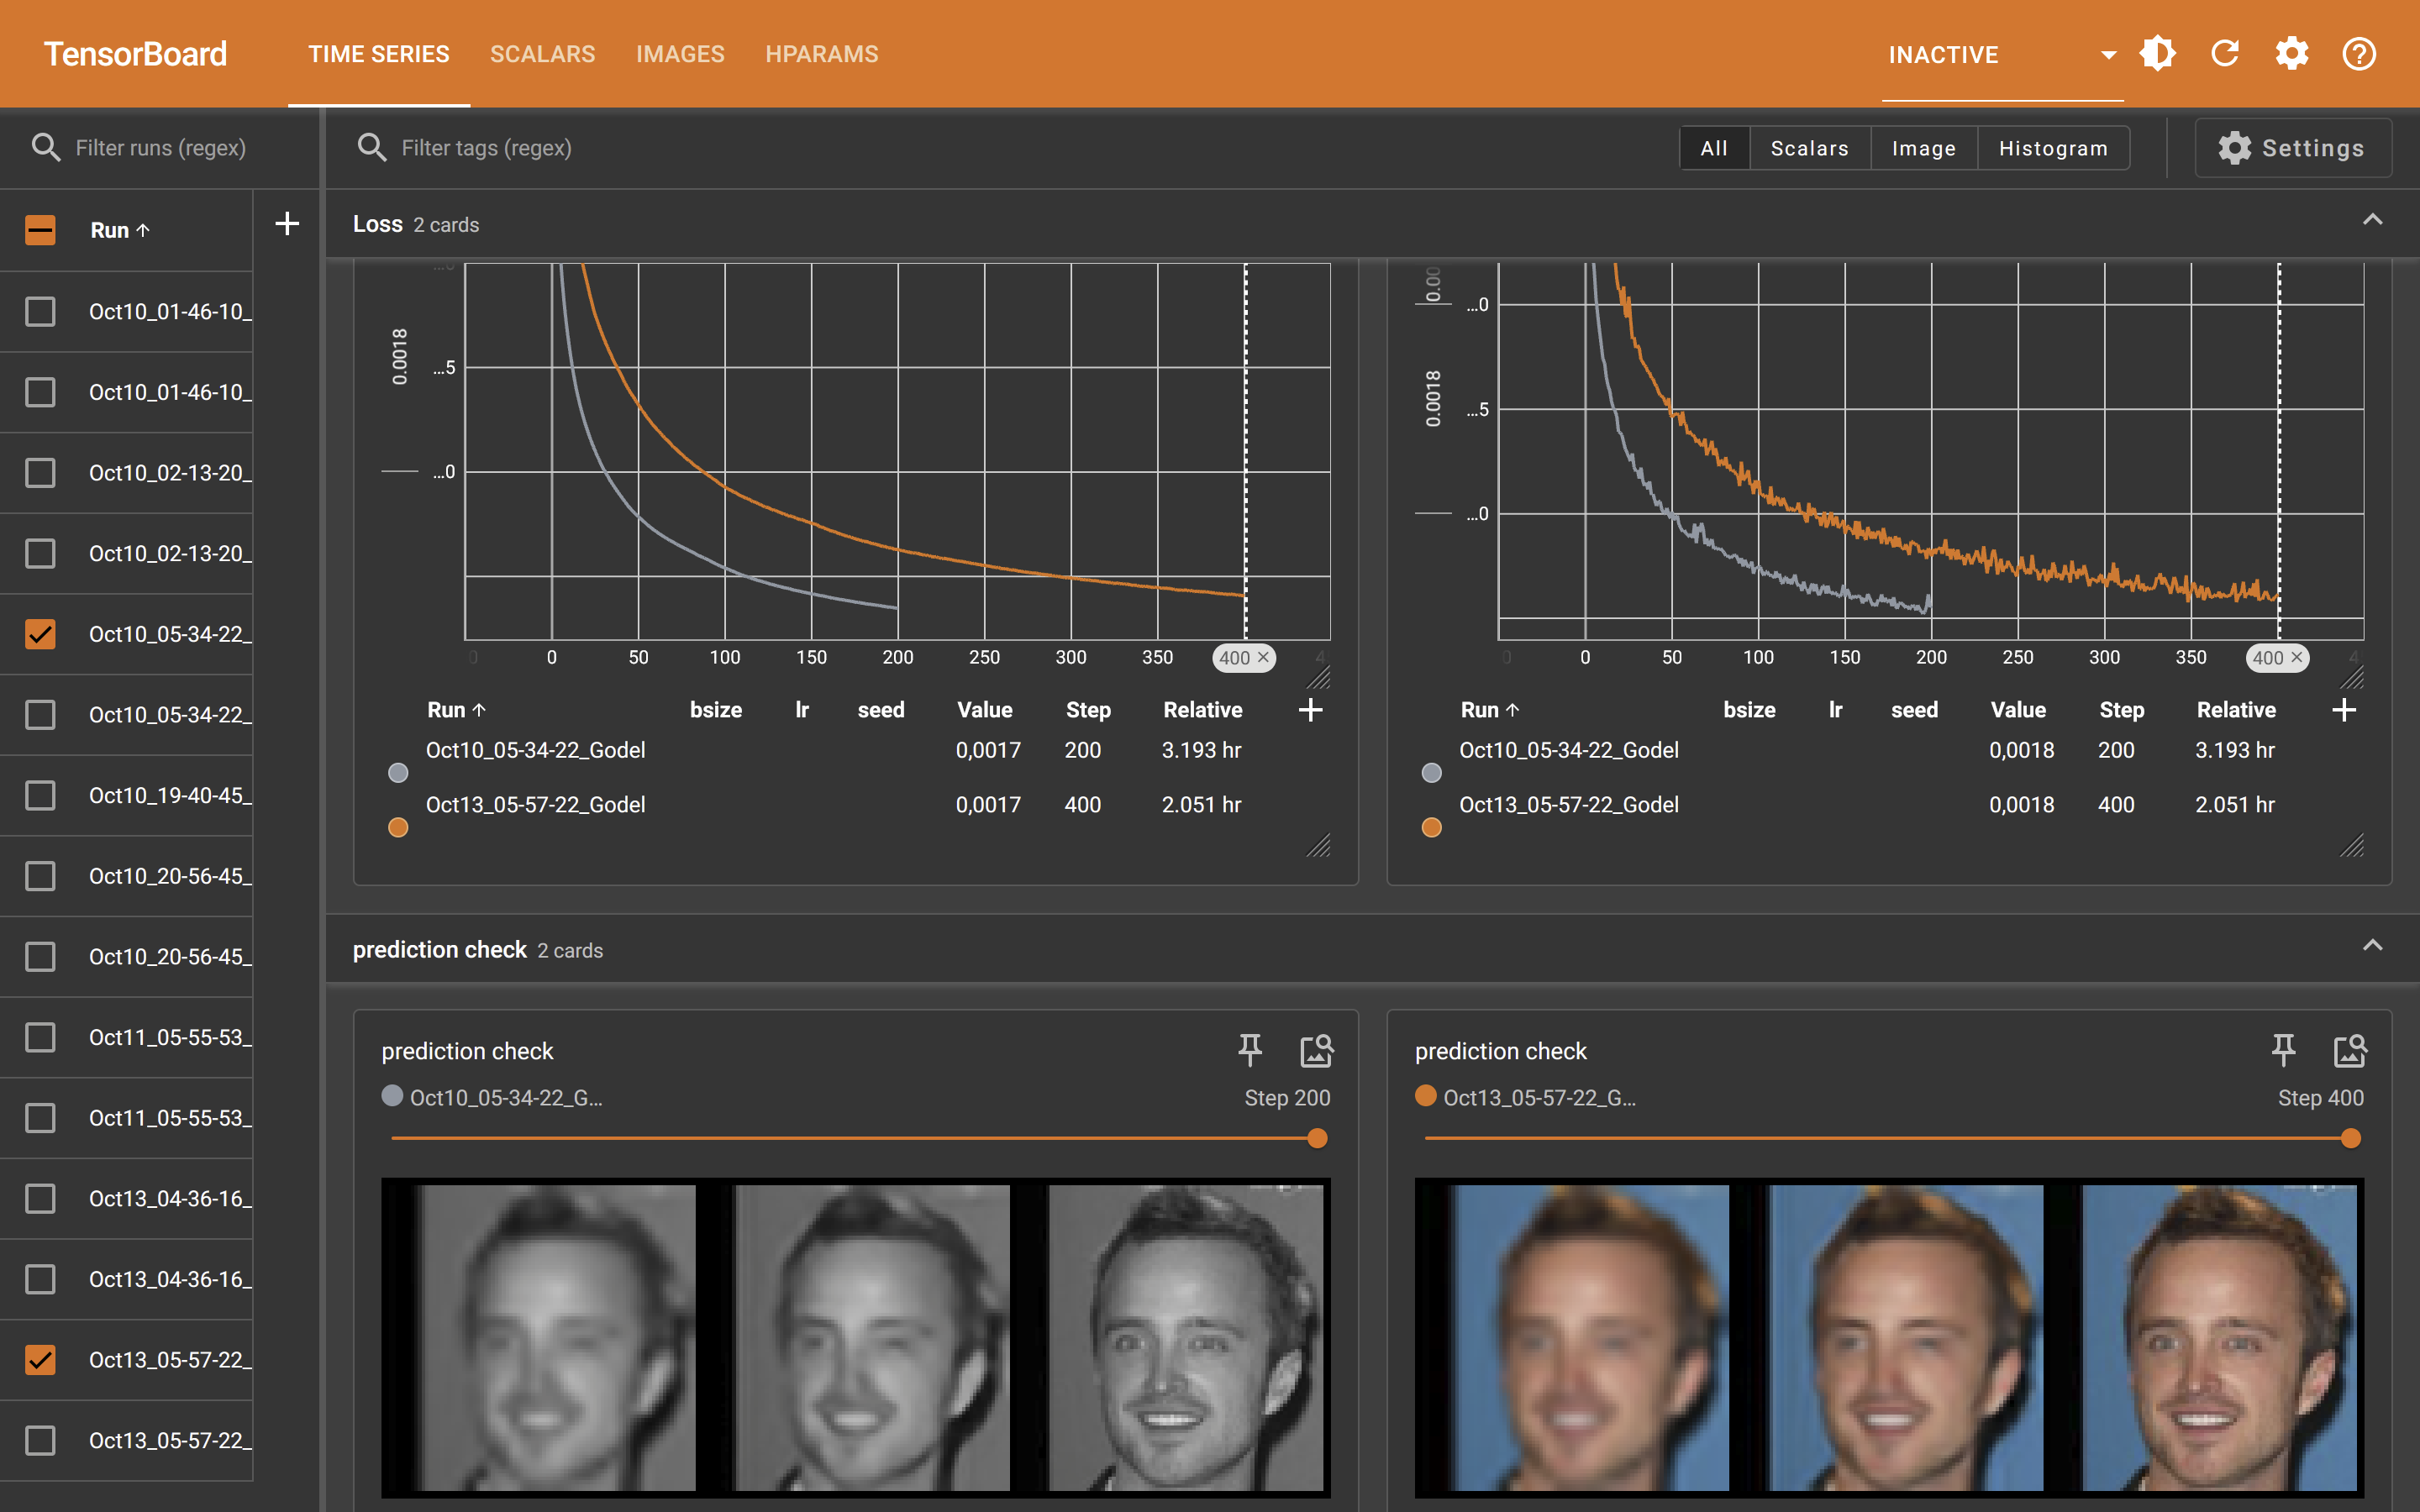

Le foto nella parte inferiore dello screenshot mostrano la ricostruzione fornita dalla rete finale, sia nel caso in scala di grigi che a colori su un'immagine del validation set.

## Valutazione sul test set

Mentre nel notebook in scala di grigi il calcolo del PSNR lasciava le immagini nel range [0, 1], qui si è cambiata la scala in quella usuale [0, 255] sui tre canali.


TEST SET
   # 1/19962 (0.0%) 0:01:50.005071
   # 1997/19962 (10.0%) 0:01:35.518772
   # 3993/19962 (20.0%) 0:01:28.764984
   # 5989/19962 (30.0%) 0:01:20.735611
   # 7985/19962 (40.0%) 0:01:12.316801
   # 9981/19962 (50.0%) 0:01:02.649612
   # 11978/19962 (60.0%) 0:00:52.019109
   # 13974/19962 (70.0%) 0:00:40.337089
   # 15970/19962 (80.0%) 0:00:27.847024
   # 17966/19962 (90.0%) 0:00:14.407250
   # 19962/19962 (100.0%) 0:00:00
   # 1/19962 (0.0%)
   # 1997/19962 (10.0%)
   # 3993/19962 (20.0%)
   # 5989/19962 (30.0%)
   # 7985/19962 (40.0%)
   # 9981/19962 (50.0%)
   # 11978/19962 (60.0%)
   # 13974/19962 (70.0%)
   # 15970/19962 (80.0%)
   # 17966/19962 (90.0%)
   # 19962/19962 (100.0%)
0:12:48.844582


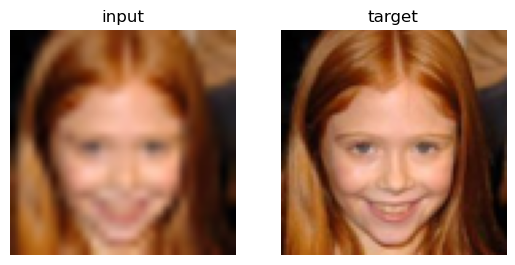

In [8]:
idTest = df_part[df_part['set']=='test'].index
df_test  = df_part.loc[idTest]
print('\nTEST SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageRgbDataset.LoadLHRImages(img_path, df_test)
teRgbDataset = ImageRgbDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
teRgbDataset.plotExample(2, False)

In [9]:
import seaborn as sns

def PSNR(img1, img2):
    # L = 1 #255
    img1 = np.array(ToPILImage()(img1)).astype(np.float64)#*L
    img2 = np.array(ToPILImage()(img2)).astype(np.float64)#*L
    mse = np.mean((img1 - img2)**2)
    # psnr = 10 * np.log10(L*L/mse)
    psnr = -10*np.log10(mse)
    return psnr

def comparePSNR(dataset, model, title, xlim=None):
    psnrIn = []
    psnrOut = []
    counter = 0
    printed = 0
    nImgs = dataset.examples()
    for k in range(nImgs):
        lr,hr = dataset.getImages(k)
        pred = model(lr)
        psnrIn.append(PSNR(lr,hr))
        psnrOut.append(PSNR(pred,hr))

        # mostra avanzamento della scomposizione in patch
        counter += 1
        perc = counter/nImgs
        perc100 = np.floor(perc*10)*10
        if printed != perc100:
            printed = perc100
            print('   # {}/{} ({}%)'.format(counter, nImgs, perc100))


    fig, ax = plt.subplots(1, 1, figsize=(8, 4.94))
    sns.histplot(psnrIn,  stat='density', ax=ax, color='cornflowerblue', edgecolor='#005e93',    label='input')
    sns.histplot(psnrOut, stat='density', ax=ax, color='orange',         edgecolor='darkorange', label='output')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', color='white', linewidth=1)
    ax.set_xlabel('PSNR')
    ax.legend(title='batch size')
    ax.set_title(title)
    if xlim != None:
        ax.set_xlim(xlim[0],xlim[1])
    plt.show()

    return (psnrIn, psnrOut)

   # 1997/19962 (10.0%)
   # 3993/19962 (20.0%)
   # 5989/19962 (30.0%)
   # 7985/19962 (40.0%)
   # 9981/19962 (50.0%)
   # 11978/19962 (60.0%)
   # 13974/19962 (70.0%)
   # 15970/19962 (80.0%)
   # 17966/19962 (90.0%)
   # 19962/19962 (100.0%)


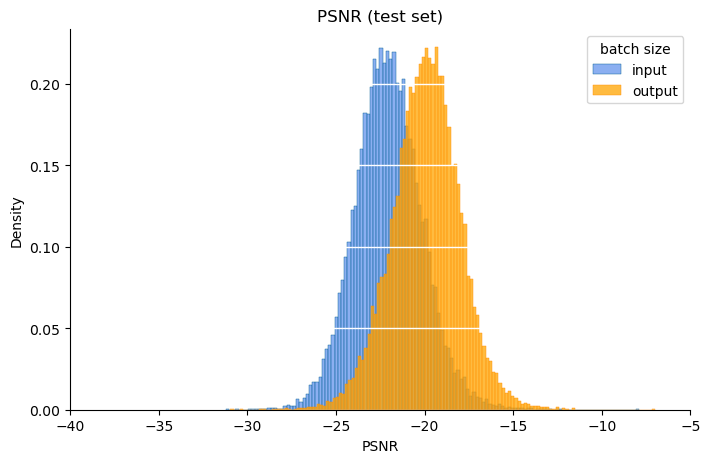

PSNR input (avg:-22.04 std.dev:1.90) vs PSNR output (avg:-19.91 std.dev:1.93)
   # 1987/19867 (10.0%)
   # 3974/19867 (20.0%)
   # 5961/19867 (30.0%)
   # 7947/19867 (40.0%)
   # 9934/19867 (50.0%)
   # 11921/19867 (60.0%)
   # 13907/19867 (70.0%)
   # 15894/19867 (80.0%)
   # 17881/19867 (90.0%)
   # 19867/19867 (100.0%)


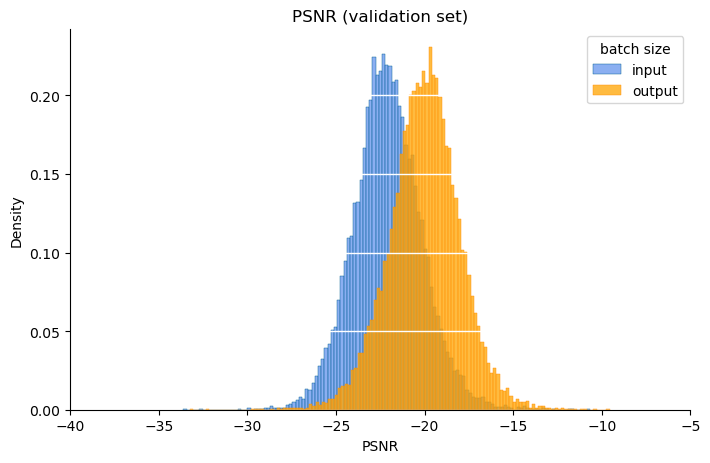

PSNR input (avg:-22.09 std.dev:1.95) vs PSNR output (avg:-20.00 std.dev:1.99)
   # 3256/32554 (10.0%)
   # 6511/32554 (20.0%)
   # 9767/32554 (30.0%)
   # 13022/32554 (40.0%)
   # 16277/32554 (50.0%)
   # 19533/32554 (60.0%)
   # 22788/32554 (70.0%)
   # 26044/32554 (80.0%)
   # 29299/32554 (90.0%)
   # 32554/32554 (100.0%)


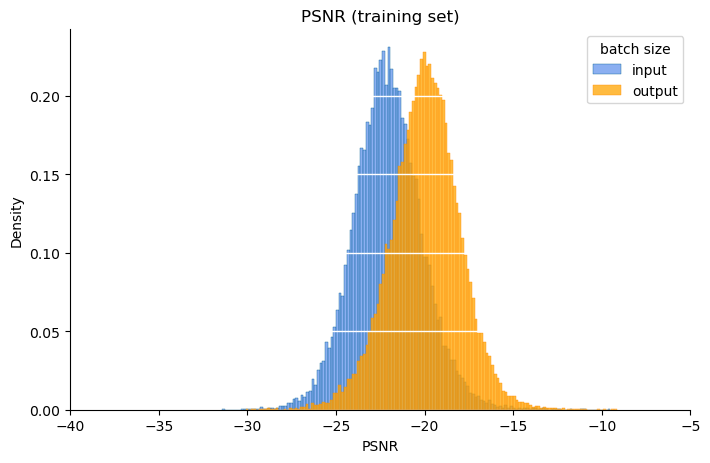

PSNR input (avg:-22.08 std.dev:1.94) vs PSNR output (avg:-19.96 std.dev:1.97)


In [13]:
rgbCnn = RgbCNN()
fname = './runs/Oct13_05-57-22_Godel/CvNet_400'
state_dict = torch.load(fname, weights_only=False)
rgbCnn.load_state_dict(state_dict)
rgbCnn.eval() #with torch_no_grad?

psnrIn, psnrOut = comparePSNR(teRgbDataset, rgbCnn, title='PSNR (test set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))

psnrIn, psnrOut = comparePSNR(vlRgbDataset, rgbCnn, title='PSNR (validation set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))

psnrIn, psnrOut = comparePSNR(trRgbDataset, rgbCnn, title='PSNR (training set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))

In generale il PSNR è migliorato rispetto alla versione in scala di grigi: la coda a sinistra nella distribuzione del PSNR sulle immagini ricostruite è sparita, traslando di fatto l'intera distribuzione di un paio di dB verso destra!

Molto probabilmente la coda osservata nella scala di grigi era dovuta al superamento del valore 1 nell'uiltmo layer della rete, cosa qui evitata grazie all'introduzione della tangente iperbolica.

## Face-book
Seguono alcuni esempi presi dai tre dataset e relativi PSNR.

In [14]:
def visualizeSR(dataset, index, model):
        (X,y) = dataset.getImages(index)
        p = model(X)
        psnrIn = PSNR(X,y)
        psnrOut = PSNR(p,y)

        # denormalizzo le immagini
        X = ImageRgbDataset.denormalize(X)
        y = ImageRgbDataset.denormalize(y)
        fig = plt.figure(figsize=(12,4))
        ax = fig.add_subplot(1, 3, 1)
        plt.imshow(np.array(ToPILImage()(X.to('cpu'))), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('input PSNR {:.3f}'.format(psnrIn))
        
        ax = fig.add_subplot(1, 3, 2)
        plt.imshow(np.array(ToPILImage()(p.to('cpu'))), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('output PSNR {:.3f}'.format(psnrOut))
    
        ax = fig.add_subplot(1, 3, 3)
        plt.imshow(np.array(ToPILImage()(y)), cmap='gray', vmin=0, vmax=255)
        ax.set_title('target')
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()


Traning # 29


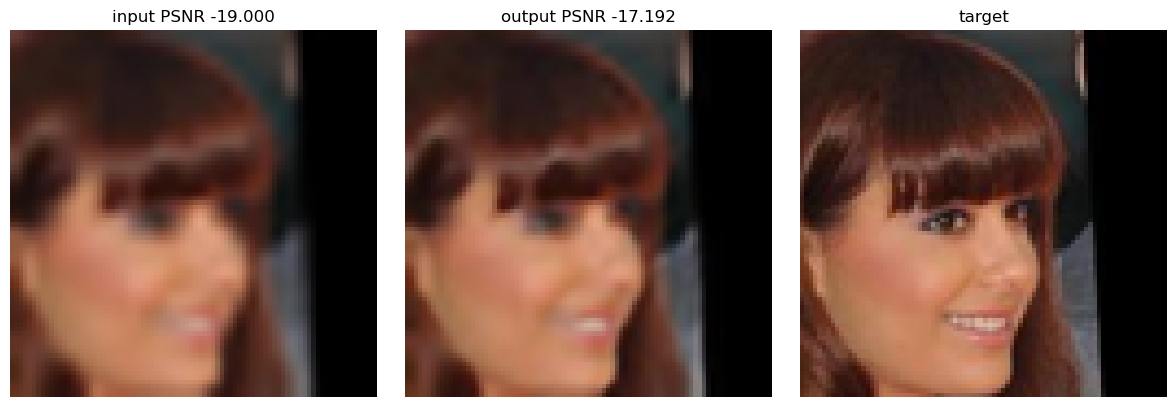


Validation # 29


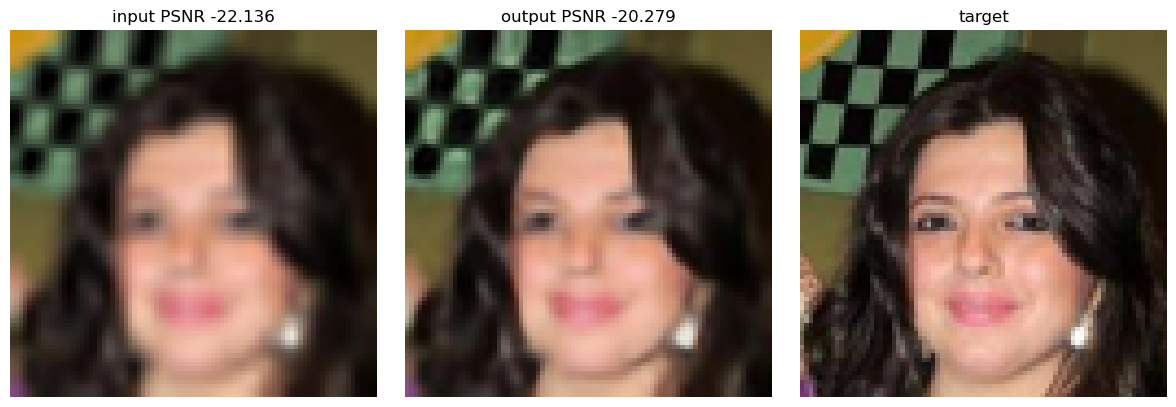


Test # 29


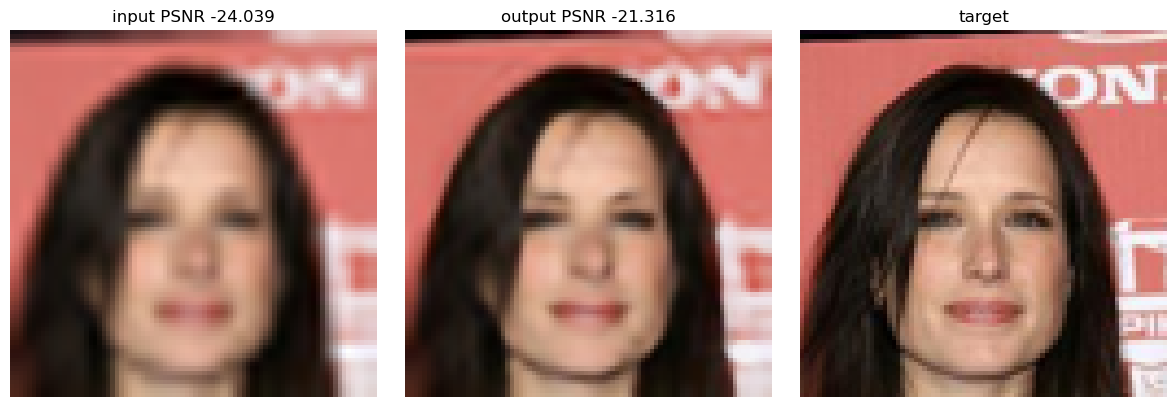


Traning # 229


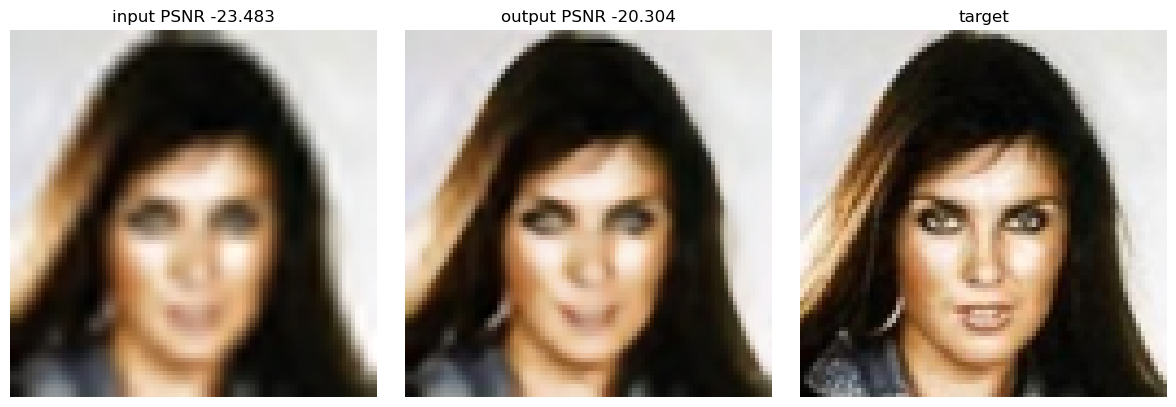


Validation # 229


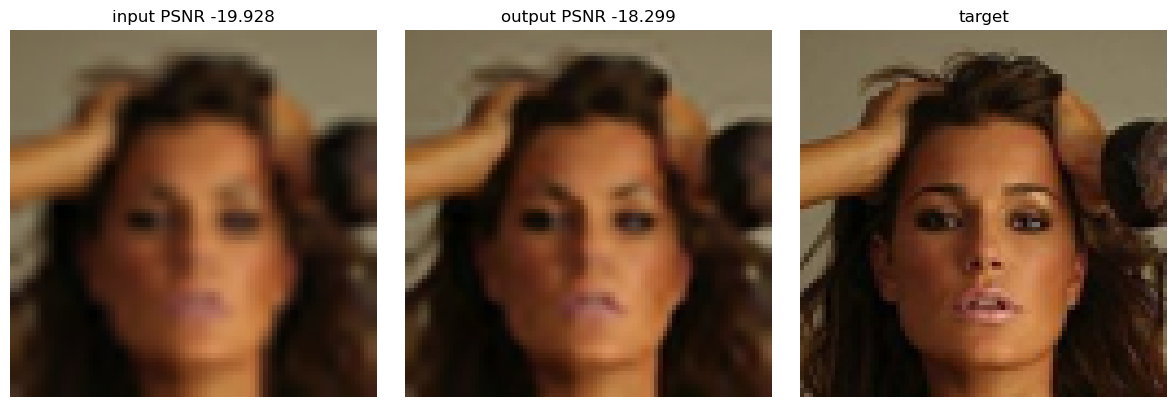


Test # 229


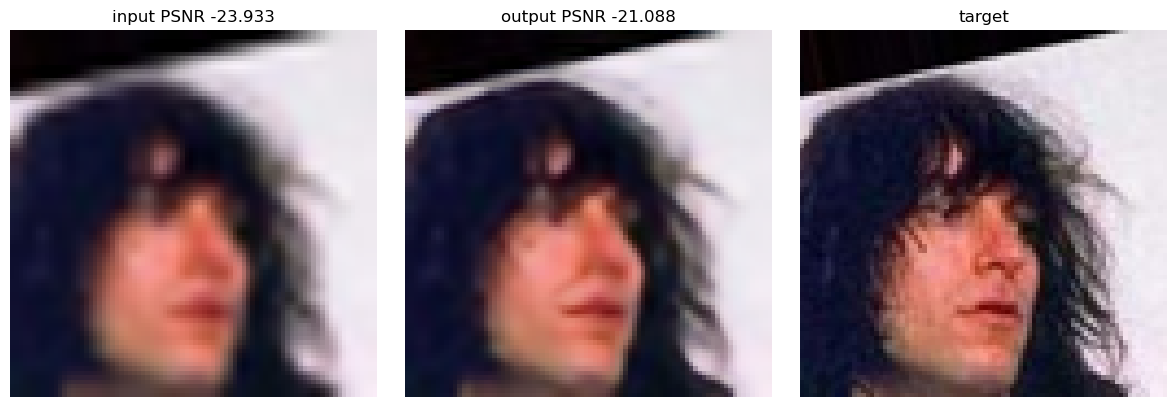


Traning # 429


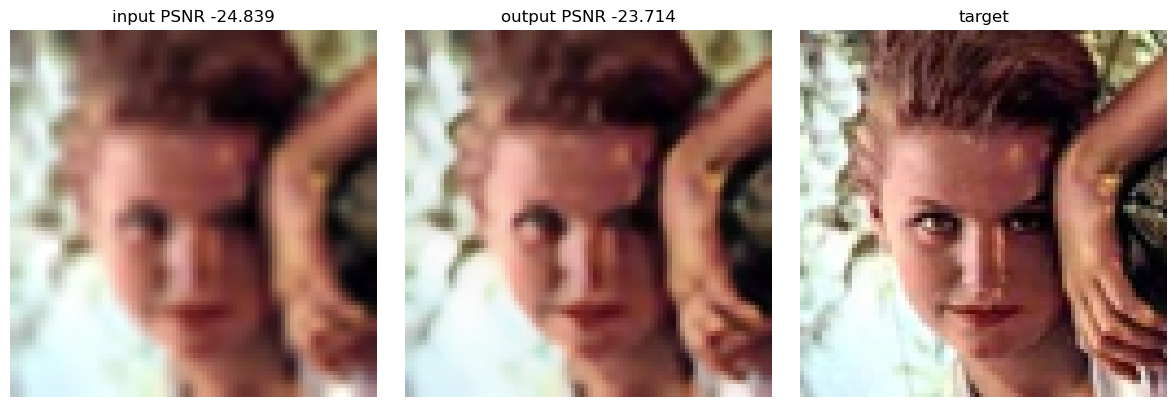


Validation # 429


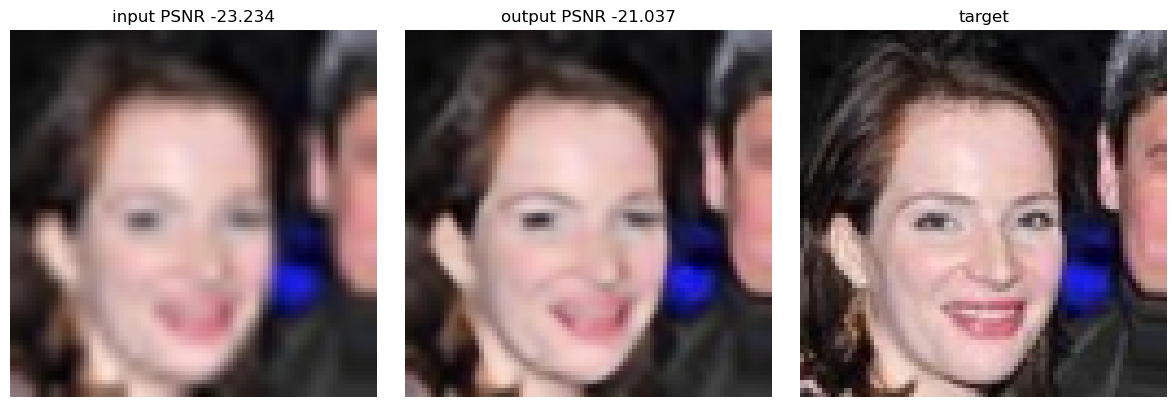


Test # 429


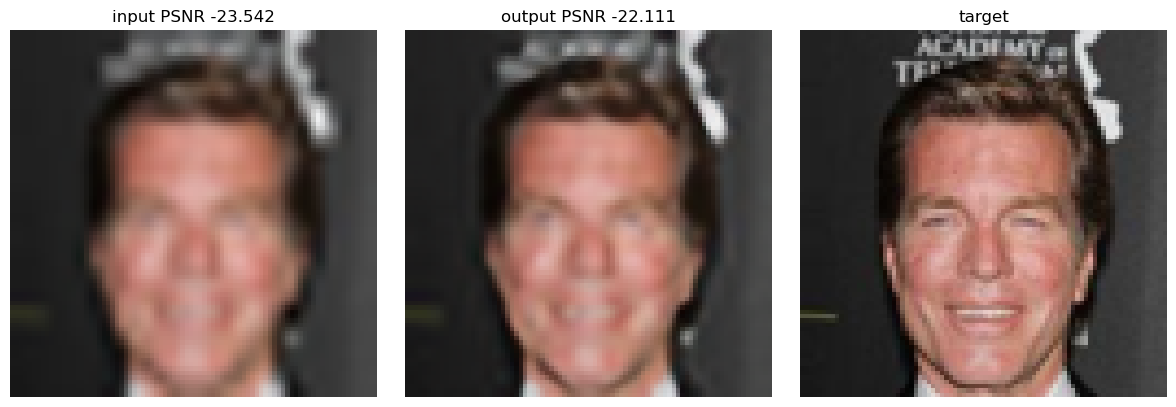


Traning # 629


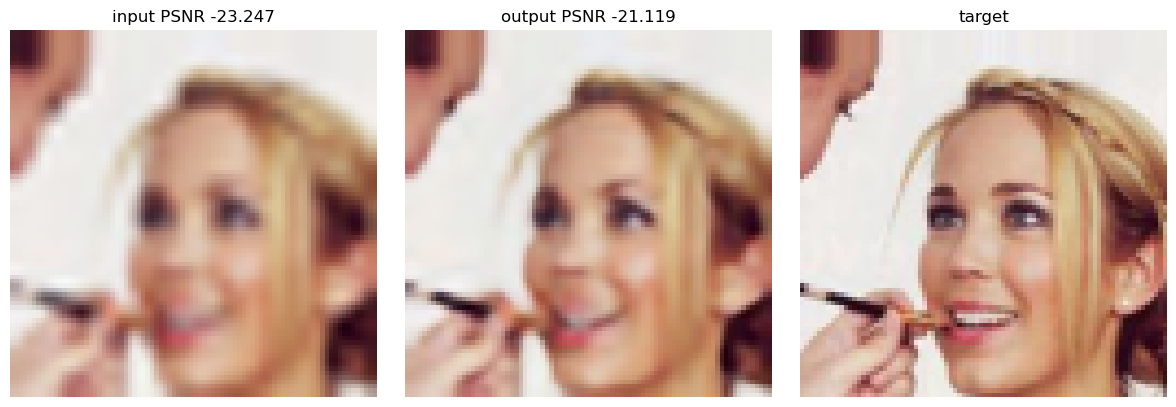


Validation # 629


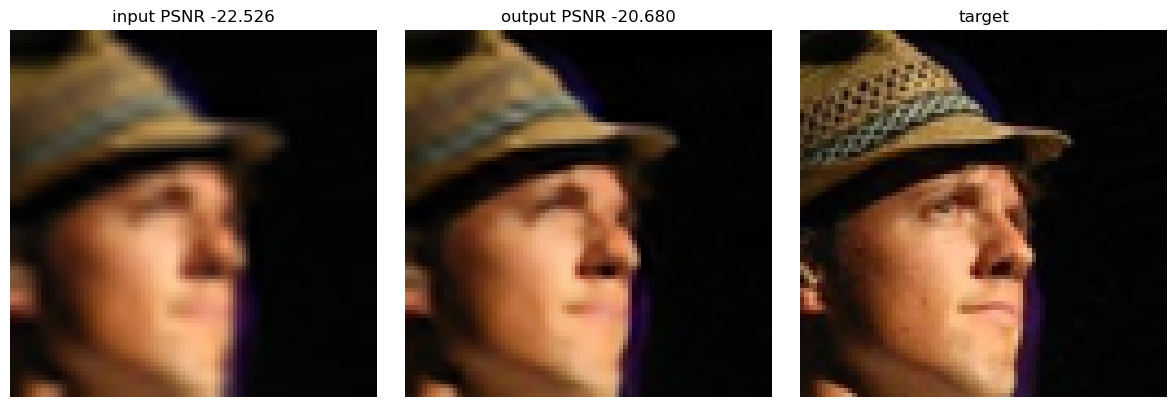


Test # 629


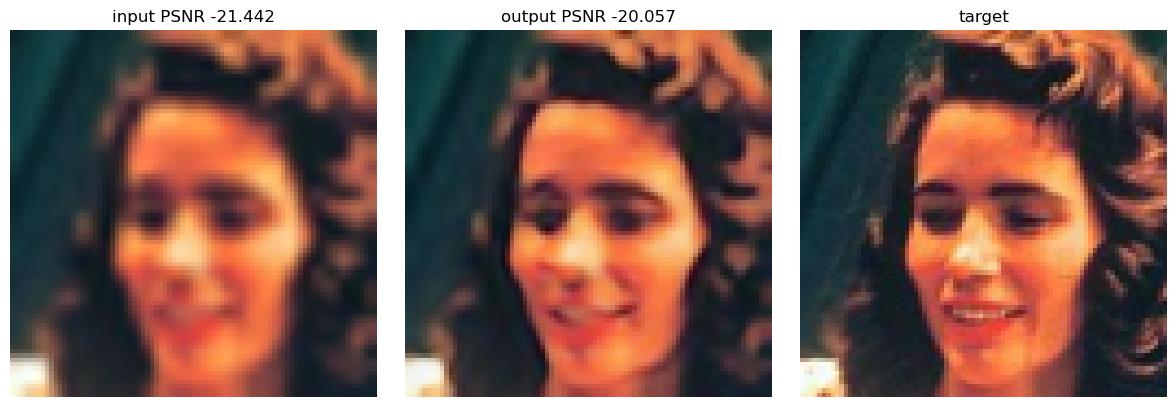


Traning # 829


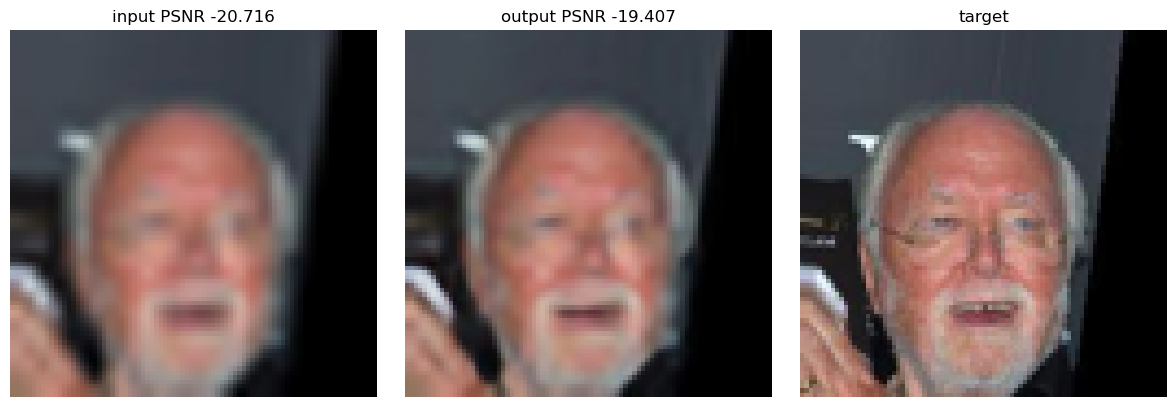


Validation # 829


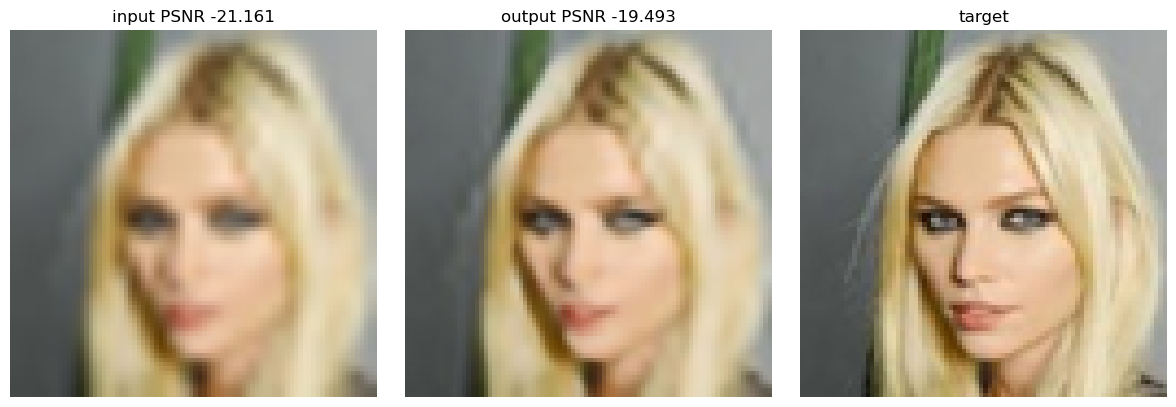


Test # 829


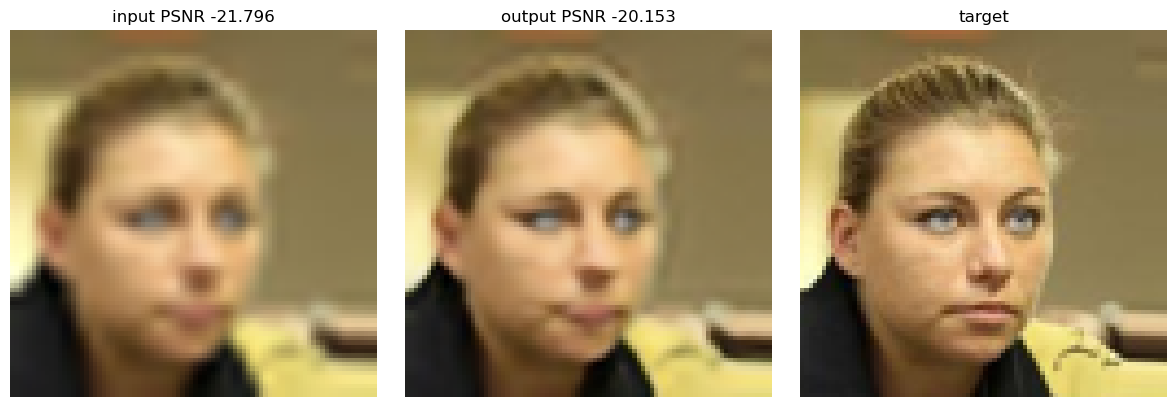

In [12]:
for k in range(5):
    index = 29+k*200
    print('\nTraning # {}'.format(index))
    visualizeSR(trRgbDataset, index, rgbCnn)
    #
    print('\nValidation # {}'.format(index))
    visualizeSR(vlRgbDataset, index, rgbCnn)
    #
    print('\nTest # {}'.format(index))
    visualizeSR(teRgbDataset, index, rgbCnn)